# Hyperparameter optimizacion - ROC One vs All approach

This notebook is not intended as a tutorial. This notebook was not properly tested and may not work as intended.

This file was **not used to execute the hyperparameter optimization**. It was used to study the results. The commands executed were:

```bash
nohup python3 code/Distribution_Analysis/hp_optimization.py --folder data/Distribution_Analysis/Hybrid_hp_RELISH --dataset RELISH --save_ROC 1 >> Hybrid_hp_RELISH.log 2>&1 &

nohup python3 code/Distribution_Analysis/hp_optimization.py --folder data/Distribution_Analysis/Hybrid_hp_TREC_simplified --dataset TREC --repurposed 1 --save_ROC 1 >> Hybrid_hp_TREC_simplified.log 2>&1 &

nohup python3 code/Distribution_Analysis/hp_optimization.py --folder data/Distribution_Analysis/Hybrid_hp_TREC_repurposed --dataset TREC --repurposed 1 --save_ROC 1 >> Hybrid_hp_TREC_repurposed.log 2>&1 &
```

# Execution

First, we need to import all the required functions.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

repository_path = os.path.expanduser("~/hybrid-dictionary-ner-doc2vec-doc-relevance")
medline_preprocessing_repository_path = os.path.expanduser("~/medline-preprocessing")

sys.path.append(f"{repository_path}/code/embeddings/")
sys.path.append(f"{medline_preprocessing_repository_path}/code/Distribution_Analysis/")
os.chdir(repository_path)

import logging
import numpy as np

import create_model as cm
import fill_relevance_matrix as frm
import counting_table as ct
import ROC_curve as ROC
import hp_optimization as hp

logging.basicConfig(format='%(asctime)s %(message)s')

## RELISH
The following code blocks test for all combinations of hyperparameters for the RELISH dataset and shows the results and plots.

In [18]:
# For RELISH
hp_df_path = "data/Hyperparameter_optimization/RELISH_hp_df.tsv"

params_d2v = {
    "dm": [0, 1],
    "vector_size": [256, 512], 
    "window": [5, 7, 9], 
    "min_count": [1, 3, 5], 
    "epochs": [15], 
    "workers": [16]}

hp_df = hp.generate_hyperparameters(params_d2v)
hp.save_file(hp_df, hp_df_path, overwrite=False)

hp.logger.setLevel("WARNING")
hp_df = hp.hyperparameter_optimization_pipeline(hp_df_path, verbose = 0, dataset = "RELISH", repurposed = False, folder_path = None, restore_search = 1, save_CT = False, save_ROC = False)
hp_df

2022-09-10 18:17:39,404 There is already a file in this path. To replace the file, please use 'overwrite = True'.


,dm,epochs,min_count,vector_size,window,workers,AUC
0,0,15,1,256,5,8,0.5820
1,0,15,1,256,7,8,0.5817
2,0,15,1,256,9,8,0.5822
3,0,15,1,512,5,8,0.5841
4,0,15,1,512,7,8,0.5841
5,0,15,1,512,9,8,0.5838
6,0,15,3,256,5,8,0.5808
7,0,15,3,256,7,8,0.5799
8,0,15,3,256,9,8,0.5806
9,0,15,3,512,5,8,0.5822


In [19]:
RELISH_best_hp = hp_df.iloc[hp_df['AUC'].idxmax()].apply(int).to_dict()
del RELISH_best_hp["AUC"]
RELISH_best_hp

{'dm': 1,
 'epochs': 15,
 'min_count': 5,
 'vector_size': 256,
 'window': 5,
 'workers': 8}

2022-09-10 18:17:50,088 	Previously generated model not found.
2022-09-10 18:18:01,539 	Generating model.
2022-09-10 18:18:13,670 	Training model.
2022-09-10 18:27:43,895 --- Time to train: 570.22 seconds
2022-09-10 18:27:43,898 	Previously generated filled relevance matrix not found.
2022-09-10 18:27:43,948 	Filling relevance matrix.
2022-09-10 18:28:12,815 --- Time to fill: 28.86 seconds


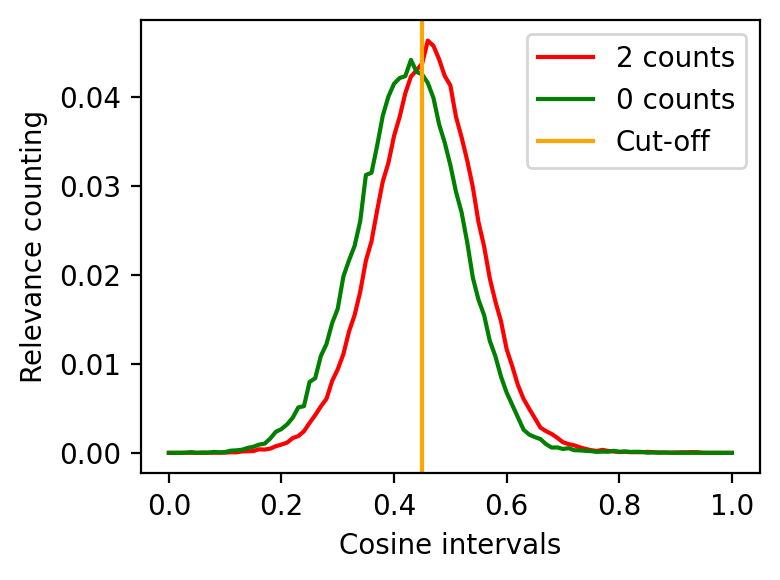

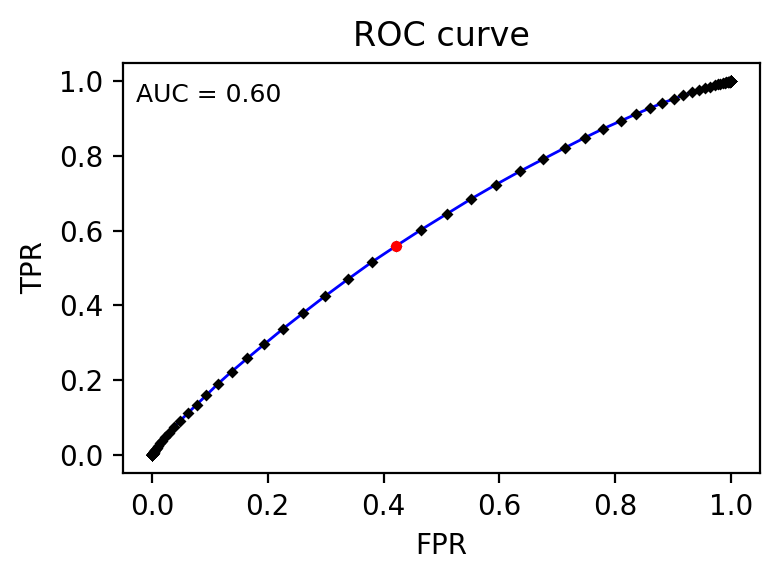

In [20]:
input_tokens = "../data_full/RELISH/RELISH_tokens.tsv"
input_frm = "../data_full/RELISH/RELISH_relevance_matrix.tsv"

hp.logger.setLevel("INFO")
filled_relevance_matrix = hp.hybrid_model_pipeline(RELISH_best_hp, input_tokens, input_frm, dataset = "RELISH", repurposed = False, verbose = 1)
counting_table = ct.hp_create_counting_table(filled_relevance_matrix, dataset = "RELISH", repurposed=False)
ROC.generate_roc_values(counting_table, dataset = "RELISH", repurposed = False)

ct.plot_graph(counting_table, dataset = "RELISH", normalize = True, best_cosine = ROC.calculate_best_cosine_interval(counting_table), output_path="data/Hyperparameter_optimization/RELISH_distribution.png")
ROC.draw_roc_curve(counting_table, draw_auc = True, output_path="data/Hyperparameter_optimization/RELISH_ROC.png")


## TREC_simplified
The following code blocks test for all combinations of hyperparameters for the TREC simplified dataset and shows the results and plots.

In [9]:
# For TREC simplified
hp_df_path = "data/Hyperparameter_optimization/TREC_simplified_hp_df.tsv"

params_d2v = {
    "dm": [0, 1],
    "vector_size": [256, 512], 
    "window": [5, 7, 9], 
    "min_count": [1, 3, 5], 
    "epochs": [15], 
    "workers": [16]}

# NOTE: Not all combinations in file are shown here. I decidd to manually add
# some extra combinations to the hp_df.tsv file
hp_df = hp.generate_hyperparameters(params_d2v)
hp.save_file(hp_df, hp_df_path, overwrite=False)

hp.logger.setLevel("WARNING")
hp_df = hp.hyperparameter_optimization_pipeline(hp_df_path, verbose = 0, dataset = "TREC", repurposed = False, restore_search = 1, save_CT = False, save_ROC = False)
hp_df

2022-09-10 18:02:07,331 There is already a file in this path. To replace the file, please use 'overwrite = True'.


,dm,epochs,min_count,vector_size,window,workers,AUC
0,0,15,1,256,5,16,0.6615
1,0,15,1,256,7,16,0.6613
2,0,15,1,256,9,16,0.6615
3,0,15,1,512,5,16,0.6607
4,0,15,1,512,7,16,0.6609
5,0,15,1,512,9,16,0.6610
6,0,15,3,256,5,16,0.6556
7,0,15,3,256,7,16,0.6560
8,0,15,3,256,9,16,0.6559
9,0,15,3,512,5,16,0.6559


In [10]:
TREC_best_hp = hp_df.iloc[hp_df['AUC'].idxmax()].apply(int).to_dict()
del TREC_best_hp["AUC"]
TREC_best_hp

{'dm': 0,
 'epochs': 15,
 'min_count': 0,
 'vector_size': 256,
 'window': 5,
 'workers': 16}

2022-09-10 18:05:55,362 	Previously generated model not found.
2022-09-10 18:05:57,554 	Generating model.
2022-09-10 18:06:01,211 	Training model.
2022-09-10 18:07:30,256 --- Time to train: 89.04 seconds
2022-09-10 18:07:30,258 	Previously generated filled relevance matrix not found.
2022-09-10 18:07:36,254 	Filling relevance matrix.
2022-09-10 18:10:07,827 --- Time to fill: 149.73 seconds


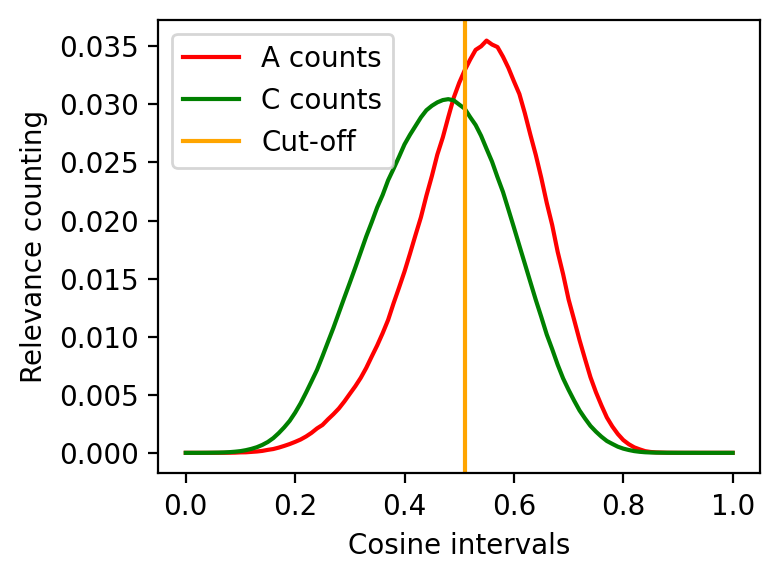

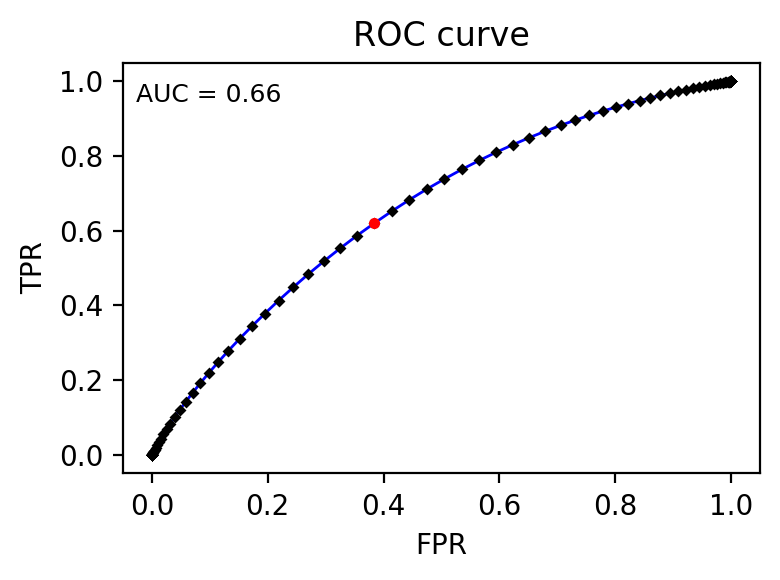

In [12]:
input_tokens = "../data_full/TREC/TREC_tokens.tsv"
input_frm = "../data_full/TREC/TREC_simplified_relevance_matrix.tsv"

hp.logger.setLevel("INFO")
filled_relevance_matrix = hp.hybrid_model_pipeline(TREC_best_hp, input_tokens, input_frm, dataset = "TREC", repurposed = False, verbose = 1)
counting_table = ct.hp_create_counting_table(filled_relevance_matrix, dataset = "TREC", repurposed=False)
ROC.generate_roc_values(counting_table, dataset = "TREC", repurposed = False)

ct.plot_graph(counting_table, dataset = "TREC", normalize = True, best_cosine = ROC.calculate_best_cosine_interval(counting_table), output_path="data/Hyperparameter_optimization/TREC_simplified_distribution.png")
ROC.draw_roc_curve(counting_table, draw_auc = True, output_path="data/Hyperparameter_optimization/TREC_simplified_ROC.png")

## TREC_repurposed
The following code blocks test for all combinations of hyperparameters for the TREC repurposed dataset and shows the results and plots.

In [15]:
# For TREC
hp_df_path = "data/Hyperparameter_optimization/TREC_repurposed_hp_df.tsv"

params_d2v = {
    "dm": [0, 1],
    "vector_size": [256, 512], 
    "window": [5, 7, 9], 
    "min_count": [1, 3, 5], 
    "epochs": [15], 
    "workers": [16]}

# NOTE: Not all combinations in file are shown here. I decidd to manually add
# some extra combinations to the hp_df.tsv file
hp_df = hp.generate_hyperparameters(params_d2v)
hp.save_file(hp_df, hp_df_path, overwrite=False)

hp.logger.setLevel("WARNING")
hp_df = hp.hyperparameter_optimization_pipeline(hp_df_path, verbose = 0, dataset = "TREC", repurposed = True, restore_search = 1, save_CT = False, save_ROC = False)
hp_df

2022-09-10 18:13:09,994 There is already a file in this path. To replace the file, please use 'overwrite = True'.


,dm,epochs,min_count,vector_size,window,workers,AUC
0,0,15,1,256,5,16,0.7823
1,0,15,1,256,7,16,0.7825
2,0,15,1,256,9,16,0.7828
3,0,15,1,512,5,16,0.7823
4,0,15,1,512,7,16,0.7819
5,0,15,1,512,9,16,0.7816
6,0,15,3,256,5,16,0.7750
7,0,15,3,256,7,16,0.7754
8,0,15,3,256,9,16,0.7747
9,0,15,3,512,5,16,0.7748


In [16]:
TREC_best_hp = hp_df.iloc[hp_df['AUC'].idxmax()].apply(int).to_dict()
del TREC_best_hp["AUC"]
TREC_best_hp

{'dm': 0,
 'epochs': 15,
 'min_count': 1,
 'vector_size': 256,
 'window': 9,
 'workers': 16}

2022-09-10 18:13:18,152 	Previously generated model not found.
2022-09-10 18:13:20,250 	Generating model.
2022-09-10 18:13:24,377 	Training model.
2022-09-10 18:14:46,898 --- Time to train: 82.52 seconds
2022-09-10 18:14:46,899 	Previously generated filled relevance matrix not found.
2022-09-10 18:14:50,186 	Filling relevance matrix.
2022-09-10 18:16:59,178 --- Time to fill: 128.28 seconds


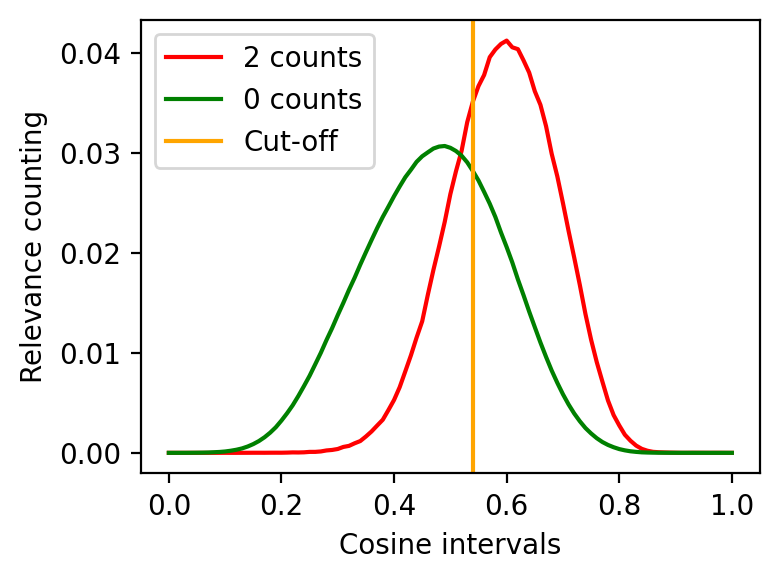

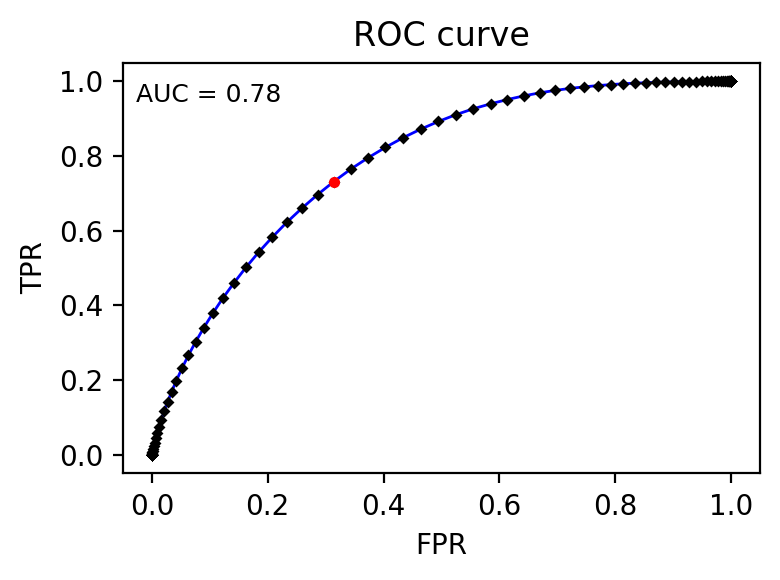

In [17]:
input_tokens = "../data_full/TREC/TREC_tokens.tsv"
input_frm = "../data_full/TREC/TREC_repurposed_matrix.tsv"

hp.logger.setLevel("INFO")
filled_relevance_matrix = hp.hybrid_model_pipeline(TREC_best_hp, input_tokens, input_frm, dataset = "TREC", repurposed = True, verbose = 1)
counting_table = ct.hp_create_counting_table(filled_relevance_matrix, dataset = "TREC", repurposed=True)
ROC.generate_roc_values(counting_table, dataset = "TREC", repurposed = True)

ct.plot_graph(counting_table, dataset = "TREC", repurposed=True, normalize = True, best_cosine = ROC.calculate_best_cosine_interval(counting_table), output_path="data/Hyperparameter_optimization/TREC_repurposed_distribution.png")
ROC.draw_roc_curve(counting_table, draw_auc = True, output_path="data/Hyperparameter_optimization/TREC_repurposed_ROC.png")

In [21]:
!jupyter nbconvert data/Hyperparameter_optimization/Hyperparameter_optimization.ipynb --to markdown --output README.md

[NbConvertApp] Converting notebook data/Hyperparameter_optimization/Hyperparameter_optimization.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Making directory data/Hyperparameter_optimization/README_files
[NbConvertApp] Making directory data/Hyperparameter_optimization/README_files
[NbConvertApp] Making directory data/Hyperparameter_optimization/README_files
[NbConvertApp] Making directory data/Hyperparameter_optimization/README_files
[NbConvertApp] Making directory data/Hyperparameter_optimization/README_files
[NbConvertApp] Making directory data/Hyperparameter_optimization/README_files
[NbConvertApp] Writing 30718 bytes to data/Hyperparameter_optimization/README.md
